In [21]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import vanet_tools as vp
from scipy.spatial import distance
from collections import defaultdict
import xml.etree.ElementTree as ET

In [10]:
pasubio_sumo = pd.read_csv('pasubio.csv',delimiter=';').dropna()

In [11]:
len(set(pasubio_sumo['vehicle_id']))

8776

In [12]:
pasubio_sumo['timestep_time'].max()

4604.0

In [14]:
coordinates = pasubio_sumo[['vehicle_x','vehicle_y']]

In [15]:
MICROCLOUD_RANGE=150
NUM_MICROCLOUDS = 10

In [27]:
microcloud_coords =vp.create_coords(coordinates,MICROCLOUD_RANGE,NUM_MICROCLOUDS)
# microcloud_coords = [[310,1200],[350,420],[920,250],[780,1000],[1400,770]]

In [ ]:
# tree = ET.parse('Bologna_small-0.29.0/pasubio/pasubio_buslanes.net.xml')
# root = tree.getroot()

In [ ]:
# microcloud_coords = []
# for neighbor in root.iter('junction'):
#     attrib = neighbor.attrib
#     if attrib.get('type')=="priority":
#         x,y = neighbor.attrib.get('x'),neighbor.attrib.get('y')
#         micro_cloud  = [int(float(x)),int(float(y))]
#         microcloud_coords.append(micro_cloud)
# microcloud_coords = microcloud_coords[:NUM_MICROCLOUDS]
# print(microcloud_coords)

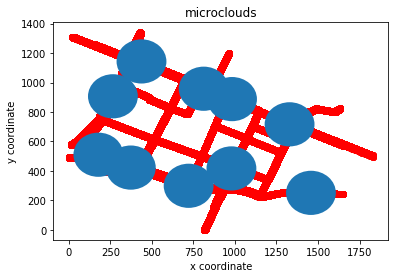

In [28]:
coords_x,coords_y = pasubio_sumo['vehicle_x'],pasubio_sumo['vehicle_y']
vp.plot_microclouds(microcloud_coords,MICROCLOUD_RANGE,coords_x,coords_y)

In [26]:
vp.store_microcloud_config(microcloud_coords,"Pasubio_config.csv")

In [18]:
time_col = pasubio_sumo['timestep_time']
start,end = int(time_col.min()), int(time_col.max())


In [19]:
time_steps= pasubio_sumo.groupby('timestep_time')

Paremeters that must be established, mininum amount of trafic for microcloud, relation of power to number of cars

In [ ]:
def determine_closest(micro_clouds,x,y):
    min_distance = float('inf')
    index_of_closest = -1
    for index,micro_cloud in enumerate(micro_clouds):
        x_coord,y_coord =  micro_cloud
        current_distance = distance.euclidean((x,y),(x_coord,y_coord))
        if current_distance<min_distance:
            min_distance = current_distance
            index_of_closest = index
    return index_of_closest
            

In [ ]:
cloud_to_power = defaultdict(list)
for time in range(start,end+1):
    time_step = time_steps.get_group(time)
    current_power = [0 for _ in range(len(microcloud_coords))]
    for index, row in time_step.iterrows():
        x,y = row['vehicle_x'],row['vehicle_y']
        index_of_closest =determine_closest(microcloud_coords,x,y)
        closest = microcloud_coords[index_of_closest]
        if distance.euclidean((closest[0],closest[1]),(x,y))<MICROCLOUD_RANGE:
            current_power[index_of_closest]+=1
    for index,power in enumerate(current_power):
        cloud_to_power[index].append(power)
            

In [ ]:
for i in range(len(microcloud_ coords)):
    plt.hist(cloud_to_power[i])
    plt.show()

In [ ]:
microcloud_range=300